In [1]:
from keras import layers
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU

# act = PReLU(init='zero', weights=None)
# conv  block 1
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# conv  block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))      
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# conv  block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))
model.summary()

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 46, 46, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 46, 46, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 44, 44, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 44, 44, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 22, 22, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 22, 22, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 64)        18496     
__________

In [5]:
from keras.preprocessing.image import ImageDataGenerator

def image_data_generator(data_dir, data_augment=False, batch_size=20, target_size=(48, 48),
                         color_mode='grayscale', class_mode='categorical', shuffle=True):
    if data_augment:
        datagen = ImageDataGenerator(rescale=1./255, 
                                    rotation_range=20,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    generator = datagen.flow_from_directory(data_dir,
                                            target_size=target_size,
                                            color_mode=color_mode,
                                            batch_size=batch_size,
                                            shuffle=shuffle,
                                            class_mode=class_mode)
    return generator

In [3]:
from keras import optimizers

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
             metrics=['acc'])

note: Because I stop the last 7 epoch training, so the first accuracy can hit 54.61%, but the architech did not change.

In [8]:
import os
base_dir = os.getcwd()
dataset_dir = os.path.join(base_dir, 'dataset')
fer2013 = os.path.join(dataset_dir, 'fer2013')
snips = os.path.join(base_dir, 'snips')

train_dir = os.path.join(fer2013, 'Training')
validation_dir = os.path.join(fer2013, 'PublicTest')
test_dir = os.path.join(fer2013, 'PrivateTest')

train_generator = image_data_generator(train_dir)
validation_generator = image_data_generator(validation_dir)
# if you relaunch the model to train, you should recompile the model before launch it!
history = model.fit_generator(train_generator,
                   steps_per_epoch=1400,
                   epochs=40,
                   validation_data=validation_generator,
                   validation_steps=179)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.
Epoch 1/40
1400/1400 [==============================] - 78s 56ms/step - loss: 1.2425 - acc: 0.5339 - val_loss: 1.2389 - val_acc: 0.5461
Epoch 2/40
1400/1400 [==============================] - 74s 53ms/step - loss: 1.2340 - acc: 0.5390 - val_loss: 1.2201 - val_acc: 0.5489
Epoch 3/40
1400/1400 [==============================] - 75s 54ms/step - loss: 1.2113 - acc: 0.5491 - val_loss: 1.2497 - val_acc: 0.5366
Epoch 4/40
1400/1400 [==============================] - 77s 55ms/step - loss: 1.1993 - acc: 0.5537 - val_loss: 1.1985 - val_acc: 0.5637
Epoch 5/40
1400/1400 [==============================] - 78s 56ms/step - loss: 1.1829 - acc: 0.5605 - val_loss: 1.2064 - val_acc: 0.5547
Epoch 6/40
1400/1400 [==============================] - 80s 57ms/step - loss: 1.1695 - acc: 0.5635 - val_loss: 1.1937 - val_acc: 0.5626
Epoch 7/40
1400/1400 [==============================] - 78s 56ms/step - loss: 1.1545 - acc: 0.5666 

In [16]:
def evaluate_model(model=None, filepath=None):
    if not model:
        model = models.load_model(filepath)
    test_generator = image_data_generator(test_dir, batch_size=1, shuffle=False)
    
    nb_samples = len(test_generator)
    predict = model.evaluate_generator(test_generator, steps=nb_samples)
    # predictions = model.predict_generator(test_generator, steps=nb_samples)
    # val_preds = np.argmax(predictions, axis=-1)
    # val_trues = validation_generator.classes
    # cm = classification_report(val_trues, val_preds)    
    return predict

In [17]:
predict = evaluate_model(model=model)
print('the accuracy of test data from scratch without data augment:', predict[1])

Found 3589 images belonging to 7 classes.
the accuracy of test data from scratch without data augment: 0.606018389524


In [23]:
from matplotlib import pyplot as plt
import numpy as np

def smooth_curve(points, factor=0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

def plt_acc_loss(history, acc_title, loss_title, acc_filepath=None, loss_filepath=None):
    """ plt the accuracy and the loss picture in `history`, and save 
    the figure to png directory with title name"""
    if not acc_filepath:
        acc_filepath = acc_title        
    if not loss_filepath:
        loss_filepath = loss_title
    acc_filepath = os.path.join(snips, acc_filepath)
    loss_filepath = os.path.join(snips, loss_filepath)
        
    acc = smooth_curve(history.history['acc'])
    val_acc = smooth_curve(history.history['val_acc'])
    loss = smooth_curve(history.history['loss'])
    val_loss = smooth_curve(history.history['val_loss'])

    epochs = range(1, len(acc) + 1)

    plt.plot(epochs, acc, 'bo', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title(acc_title)
    plt.legend()
    plt.grid(True)
    plt.savefig(acc_filepath)
    plt.figure()

    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title(loss_title)
    plt.grid(True)
    plt.legend()
    plt.savefig(loss_filepath)
    plt.show()

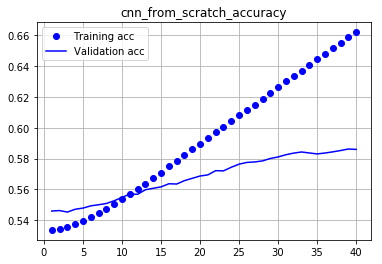

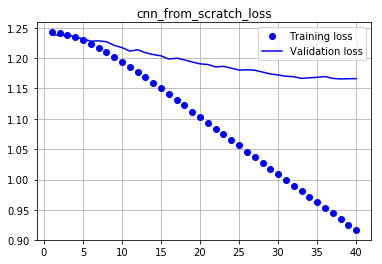

In [24]:
plt_acc_loss(history, 'cnn_from_scratch_accuracy', 'cnn_from_scratch_loss', 
             'cnn_from_scratch_accuracy(60.60%).png', 'cnn_from_scratch_loss(60.60%).png')

In [26]:
from sklearn.metrics import classification_report
from keras.preprocessing.image import ImageDataGenerator
from keras import models
import numpy as np
# from keras.utils.np_utils import categorical_probas_to_classes # ImportError?

test_generator = image_data_generator(test_dir, shuffle=False, batch_size=1)

def probas_to_classes(y_pred):
    if len(y_pred.shape) > 1 and y_pred.shape[1] > 1:
        return np.argmax(y_pred, axis=1)
    return np.array([1 if p > 0.5 else 0 for p in y_pred])

def evaluate_emotions_error_rate(model, sample_count=3589, batch_size=1):
    """evaluate the error rate of each emotion"""   
    Y_test = np.zeros(shape=sample_count)
    Y_pred = np.zeros(shape=sample_count)
    i = 0
    for X, labels_batch in test_generator:
        # Y_pred[i] = model.predict_classes(X)
        pred = model.predict(X)
        Y_pred[i] = probas_to_classes(pred)
        Y_test[i*batch_size: (i+1)*batch_size] = np.argmax(labels_batch, axis=1)  # convert one=hot encode to index
        i += 1   
        if i * batch_size >= 3589:
            break
    x_num, y_num = [0]*7, [0]*7    
    for pred, test in zip(Y_pred, Y_test):
        y_num[int(test)] += 1
        if pred != test: # predict error
            x_num[int(test)] += 1
            
    err = [i/j for i, j in zip(x_num, y_num)]
    return err

Found 3589 images belonging to 7 classes.


In [27]:
err_emotions = evaluate_emotions_error_rate(model)

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

def plt_emotions(err, title):
    s = pd.Series(
        err,
        index = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
    )

    plt.title(title)
    plt.ylabel('error rate')
    plt.xlabel('emotions')

    #Plot the data:
    my_colors = 'rykgmbc' # red yellow black green .. blue ..    

    s.plot(
        kind='bar', 
        color=my_colors,
    )
    pngfile = os.path.join(snips, title+'.png')
    plt.savefig(pngfile)
    plt.show()

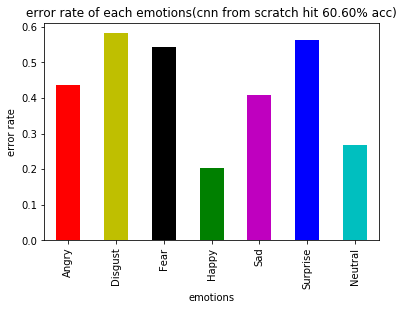

In [31]:
plt_emotions(err_emotions, 'error rate of each emotions(cnn from scratch hit %.2f%% acc)' % (predict[1] * 100))

In [49]:
def save_model(model, filename):
    Models = os.path.join(os.getcwd(), 'Models')
    filepath = os.path.join(Models, filename)
    if filename.endswith('h5'):
        model.save(filepath)
    elif filename.endswith('json'):
        model.to_json(filepath)

from keras import models

def load_model(filename):
    Model = os.path.join(os.getcwd(), 'Models')
    filepath = os.path.join(Model, filename)
    model = None
    if filename.endswith('h5'):
        model = models.load_model(filepath)
    elif filename.endswith('json'):
        with open('model.json', 'r') as json_file:
            loaded_model_json = json_file.read()           
            model = models.model_from_json(loaded_model_json)
    return model


In [45]:
save_model(model, 'cnn from scratch with softmax 50epoch hit 60.60% acc.h5')

In [50]:
model = load_model('softmax_crossentropy_60epoch_dropout(0.5)1024hit(0.6163).h5')  # load the 62.63% model, not just trained
predict = evaluate_model(model=model)
print('the accuracy of test data from scratch without data augment:', predict[1])

Found 3589 images belonging to 7 classes.
the accuracy of test data from scratch without data augment: 0.616327667874


### Using data augmentation

In [52]:
from keras import layers
from keras import models
from keras.layers.normalization import BatchNormalization
from keras.layers import Activation
from keras.layers.advanced_activations import PReLU

# act = PReLU(init='zero', weights=None)
# conv  block 1
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), input_shape=(48, 48, 1), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# conv  block 2
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.Conv2D(64, (3, 3), activation='relu'))      
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.25))
# conv  block 3
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization(axis=-1))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1024, activation='relu'))
model.add(layers.Dense(7, activation='softmax'))

train_generator = image_data_generator(train_dir, data_augment=True)
validation_generator = image_data_generator(validation_dir)

Found 28709 images belonging to 7 classes.
Found 3589 images belonging to 7 classes.


In [53]:

model.compile(loss='categorical_crossentropy',
             optimizer=optimizers.RMSprop(lr=1e-4, decay=1e-6),
             metrics=['acc'])

history = model.fit_generator(train_generator,
                   steps_per_epoch=1400,
                   epochs=50,
                   validation_data=validation_generator,
                   validation_steps=179)

Epoch 1/50
1400/1400 [==============================] - 77s 55ms/step - loss: 2.1357 - acc: 0.2149 - val_loss: 1.8418 - val_acc: 0.2670
Epoch 2/50
1400/1400 [==============================] - 76s 54ms/step - loss: 1.8846 - acc: 0.2376 - val_loss: 2.0003 - val_acc: 0.2849
Epoch 3/50
1400/1400 [==============================] - 75s 53ms/step - loss: 1.8268 - acc: 0.2591 - val_loss: 3.0773 - val_acc: 0.2712
Epoch 4/50
1400/1400 [==============================] - 75s 54ms/step - loss: 1.8014 - acc: 0.2702 - val_loss: 3.3321 - val_acc: 0.2911
Epoch 5/50
1400/1400 [==============================] - 75s 54ms/step - loss: 1.7704 - acc: 0.2891 - val_loss: 2.4100 - val_acc: 0.3201
Epoch 6/50
1400/1400 [==============================] - 75s 53ms/step - loss: 1.7615 - acc: 0.2955 - val_loss: 2.5336 - val_acc: 0.3385
Epoch 7/50
1400/1400 [==============================] - 75s 53ms/step - loss: 1.7457 - acc: 0.3054 - val_loss: 1.8369 - val_acc: 0.3567
Epoch 8/50
1400/1400 [==========================

In [54]:
predict = evaluate_model(model=model)
print('the accuracy of test data from scratch with data augment:', predict[1])

Found 3589 images belonging to 7 classes.
the accuracy of test data from scratch with data augment: 0.536918361661


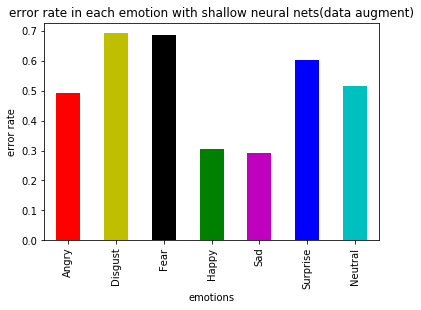

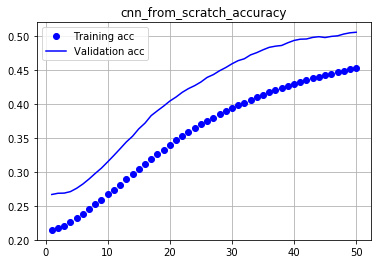

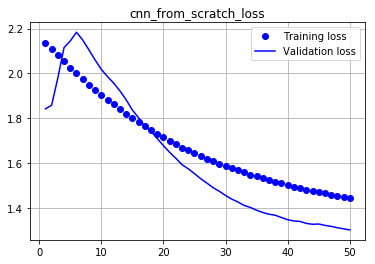

In [57]:
err_emotions = evaluate_emotions_error_rate(model)
plt_emotions(err_emotions, 'error rate in each emotion with shallow neural nets(data augment)')
plt_acc_loss(history, 'cnn_from_scratch_accuracy', 'cnn_from_scratch_loss', 
             'cnn_from_scratch_accuracy(data augment53.69%).png', 'cnn_from_scratch_loss(data augment53.69%).png')

In [59]:
save_model(model, 'cnn from scratch with softmax(data augment) 50epoch hit %.2f%% acc.h5' % (predict[1] * 100))